<a href="https://colab.research.google.com/github/amaj8/HackerEarth-Deep-Learning-Challenge-Tis-STILL-the-season-to-be-jolly/blob/main/vgg16_and_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
from skimage import io
from skimage import transform as tr
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from time import time


plt.ion()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
path = '/content/drive/MyDrive/HackerEarth Holiday Season Challenge/input_dataset/dataset/train.csv'
train = pd.read_csv(path)
train.shape

(6469, 2)

In [ ]:
from sklearn import preprocessing
labels = ['Miscellaneous','Christmas_Tree','Jacket','Candle','Airplane','Snowman']
le = preprocessing.LabelEncoder()
le.fit(labels)

LabelEncoder()

In [ ]:
train.Class = le.transform(train.Class)
train.head()

,Image,Class
0,image3476.jpg,4
1,image5198.jpg,1
2,image4183.jpg,5
3,image1806.jpg,4
4,image7831.jpg,4


In [ ]:
train.to_csv('train2.csv',index=False)

In [ ]:
class HolidayDataset(Dataset):
    def __init__(self,csv_file, root_dir,transform = None):
        self.csv = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self,idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
#         print(idx)
        img_name = os.path.join(self.root_dir, self.csv.iloc[idx,0])
        # converting gray to rgb because some images seem to be grayscale
        image = gray2rgb(io.imread(img_name))
        label = np.array(self.csv.iloc[idx,1])
#         sample = {'image':image, 'label':label}
#         sample['image'].permute(1,2,0)
        
        if self.transform:
#             print(sample.type())
#             sample['image'] = self.transform(sample['image'])
#             sample = self.transform(sample)
            image = self.transform(image)
            
        return (image,label)
        

In [ ]:
# resizing so that all tensors are of the same size
transf = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
#                                 transforms.Grayscale(3)
#                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                               ])


In [ ]:
csv_file_path = 'train2.csv'
root_dir_path = '/content/drive/MyDrive/HackerEarth Holiday Season Challenge/input_dataset/dataset/train'
holiday_data_train = HolidayDataset(csv_file = csv_file_path,
                             root_dir = root_dir_path,
                             transform = transf)

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_set, valid_set = torch.utils.data.random_split(holiday_data_train,[5000,len(holiday_data_train)-5000])
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

In [ ]:
def accuracy(net,loader):
    correct = 0
    total = 0
    net.eval()
    for data in loader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _,predicted = torch.max(outputs,1)
        correct += (predicted == labels).float().sum()
        total += labels.size(0)
        
    return correct/total * 100.0

In [ ]:
def train_model(model, train_loader, valid_loader, loss_criterion, optimizer, epochs):
    start_time = time()
    losses = []
    train_acc = []
    valid_acc = []

    for epoch in range(epochs):
        running_loss = 0.0

        for i,data in enumerate(train_loader):
    #         print(i)
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 2000:
                print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss))
    #             running_loss = 0.0

        epoch_loss = running_loss/len(train_loader)
        losses.append(epoch_loss)
        train_acc.append(accuracy(model,train_loader))
        valid_acc.append(accuracy(model,valid_loader))

    print('Finished Training')
    train_time = time() - start_time
    return {'epoch_loss':losses, 'train_acc': train_acc, 'valid_acc':valid_acc, 'train_time': train_time}
    
        

In [ ]:
import torchvision.models as models

# Ensemble of VGG16 and Resnet50

In [ ]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
  param.requires_grad_(False)


In [ ]:
resnet50 = models.resnet50(pretrained=True)
for param in resnet50.parameters():
  param.requires_grad_(False)

# resnet50.to(device)

In [ ]:
class MyEnsemble(nn.Module):
    def __init__(self,modelA, modelB, nb_classes =6):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelA.classifier[6] = nn.Identity()
        self.modelB.fc = nn.Identity()
        
#         self.classifier = nn.Linear(2048 + 4096, nb_classes)
        self.classifier = nn.Sequential(
                            nn.Linear(2048 + 4096,1024),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(1024,512),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(512,256),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(256,6),
                            
                            
                                )
        
    def forward(self,x):
        x1 = self.modelA(x.clone())
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0),-1)
        x = torch.cat((x1,x2), dim = 1)
        
        x = self.classifier(F.relu(x))
        return x

In [ ]:
model = MyEnsemble(vgg16,resnet50)
model.to(device)

MyEnsemble(
  (modelA): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [ ]:
LR = 0.001
EPOCHS = 20
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = LR)

In [ ]:
results = train_model(model, train_loader, valid_loader, criterion, optimizer, EPOCHS)

[1,     2] loss: 3.630
[1,     3] loss: 5.458
[1,     4] loss: 7.276
[1,     5] loss: 9.103
[1,     6] loss: 10.909
[1,     7] loss: 12.723
[1,     8] loss: 14.547
[1,     9] loss: 16.359
[1,    10] loss: 18.183
[1,    11] loss: 20.019
[1,    12] loss: 21.829
[1,    13] loss: 23.651
[1,    14] loss: 25.463
[1,    15] loss: 27.276
[1,    16] loss: 29.096
[1,    17] loss: 30.913
[1,    18] loss: 32.731
[1,    19] loss: 34.549
[1,    20] loss: 36.364
[1,    21] loss: 38.176
[1,    22] loss: 39.989
[1,    23] loss: 41.802
[1,    24] loss: 43.612
[1,    25] loss: 45.421
[1,    26] loss: 47.261
[1,    27] loss: 49.085
[1,    28] loss: 50.909
[1,    29] loss: 52.737
[1,    30] loss: 54.552
[1,    31] loss: 56.364
[1,    32] loss: 58.175
[1,    33] loss: 59.997
[1,    34] loss: 61.821
[1,    35] loss: 63.643
[1,    36] loss: 65.451
[1,    37] loss: 67.275
[1,    38] loss: 69.102
[1,    39] loss: 70.931
[1,    40] loss: 72.743
[1,    41] loss: 74.546
[1,    42] loss: 76.382
[1,    43] loss: 78.

In [ ]:
print(results['train_time']/60)

In [ ]:
plt.plot(range(EPOCHS),np.array(results['train_acc']))
plt.plot(range(EPOCHS),np.array(results['valid_acc']))
plt.show()

# InceptionV3

In [ ]:
inception = models.inception_v3(pretrained=True)
inception.aux_logits= False
for param in inception.parameters():
  param.requires_grad_(False)
inception

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
inception.fc = nn.Sequential(nn.Linear(2048,256),
                            nn.ReLU(),
                            nn.Dropout(0.4),
                            nn.Linear(256,6))

In [ ]:
model = inception
model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
LR = 0.001
EPOCHS = 20

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = LR)

In [ ]:
results = train_model(model,train_loader,valid_loader,criterion,optimizer,EPOCHS)

[1,     2] loss: 1.823
[1,     3] loss: 2.716
[1,     4] loss: 3.419
[1,     5] loss: 4.134
[1,     6] loss: 4.893
[1,     7] loss: 5.515
[1,     8] loss: 6.660
[1,     9] loss: 7.440
[1,    10] loss: 8.321
[1,    11] loss: 9.011
[1,    12] loss: 9.819
[1,    13] loss: 10.681
[1,    14] loss: 11.722
[1,    15] loss: 12.675
[1,    16] loss: 13.398
[1,    17] loss: 14.185
[1,    18] loss: 14.975
[1,    19] loss: 15.880
[1,    20] loss: 16.767
[1,    21] loss: 17.530
[1,    22] loss: 18.389
[1,    23] loss: 19.082
[1,    24] loss: 19.974
[1,    25] loss: 20.768
[1,    26] loss: 21.656
[1,    27] loss: 22.194
[1,    28] loss: 23.087
[1,    29] loss: 23.795
[1,    30] loss: 24.448
[1,    31] loss: 25.366
[1,    32] loss: 25.876
[1,    33] loss: 26.922
[1,    34] loss: 27.873
[1,    35] loss: 28.851
[1,    36] loss: 29.374
[1,    37] loss: 30.165
[1,    38] loss: 30.837
[1,    39] loss: 31.561
[1,    40] loss: 32.107
[1,    41] loss: 32.998
[1,    42] loss: 33.542
[1,    43] loss: 34.469
[1,

In [ ]:
print(results['train_time']/60)

46.56276630957921


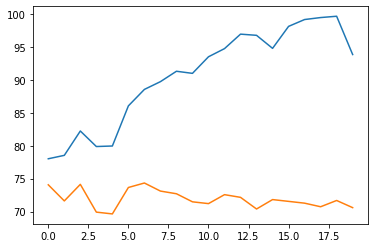

In [ ]:
plt.plot(range(EPOCHS),np.array(results['train_acc']))
plt.plot(range(EPOCHS),np.array(results['valid_acc']))
plt.show()

In [ ]:
plt.plot(np.array(results['train_acc']))

In [ ]:
plt.plot(np.array(results['valid_acc']))

In [ ]:
plt.plot(np.array(results['epoch_loss']))

In [ ]:
accuracy(model,train_loader)

tensor(93.8600, device='cuda:0')

In [ ]:
accuracy(model,valid_loader)

tensor(70.5922, device='cuda:0')

# To generate the output file

In [ ]:
from distutils.dir_util import copy_tree
from_dir = '/content/drive/MyDrive/HackerEarth Holiday Season Challenge/input_dataset/dataset/test'
to_dir = '/content/drive/MyDrive/HackerEarth Holiday Season Challenge/test_dataset'
copy_tree(from_dir,to_dir)

KeyboardInterrupt: ignored

In [ ]:
from torchvision import datasets
test_data = datasets.ImageFolder('/content/drive/MyDrive/HackerEarth Holiday Season Challenge/test_dataset', transform=transf)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False,num_workers=0)

In [ ]:
predictions = []
for i,data in enumerate(test_loader):
        inputs,labels = data
        inputs = inputs.to(device)
#         print(np.array(inputs.cpu()))
        labels = labels.to(device)
#         print(np.array(labels.cpu()))
        outputs = model(inputs)
        _,predicted = torch.max(outputs,1)
        
#         print(predicted)
#         print(np.array(predicted.cpu()))
#         np.array(inputs.cpu()
        predictions.extend(le.inverse_transform([x for x in np.array(predicted.cpu())]))
    
        if i % 10 == 0:
            print(i)
        
#         zip(le.inverse_transform([x for x in np.array(predicted.cpu())]))
    
#         break
        

0
10
20
30
40
50
60
70
80
90
100


In [ ]:
df = pd.DataFrame(zip([x[0].split('/')[-1] for x in test_data.imgs],predictions),columns=['Image', 'Class'])
df.head()

,Image,Class
0,image10.jpg,Miscellaneous
1,image100.jpg,Airplane
2,image1013.jpg,Jacket
3,image1014.jpg,Miscellaneous
4,image1018.jpg,Miscellaneous


In [ ]:
df.to_csv('output.csv',index=False)